In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import plotly.offline as pyo
# import plotly.graph_objects as go
# import plotly.io as pio
# import plotly.express as px
import time
import os
import seaborn as sns
import sklearn

In [2]:
# !pip install xgboost
# !pip install lightgbm

In [2]:
df = pd.read_csv("../data/definitivo.csv")
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1113 entries, 0 to 1112
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   municipio           1113 non-null   int64  
 1   tipo_vivienda       1113 non-null   int64  
 2   habitaciones        1113 non-null   float64
 3   metros_cuadrados    1113 non-null   float64
 4   aseos               1113 non-null   float64
 5   planta              1113 non-null   float64
 6   garaje              1113 non-null   int64  
 7   zona_centro         1113 non-null   int64  
 8   ascensor            1113 non-null   int64  
 9   piscina             1113 non-null   int64  
 10  reformado           1113 non-null   int64  
 11  terraza             1113 non-null   int64  
 12  aire_acondicionado  1113 non-null   int64  
 13  precio              1113 non-null   float64
dtypes: float64(5), int64(9)
memory usage: 121.9 KB


### **VOTING REGRESSOR**. 
### Técnica de ensemble que **combina las predicciones de múltiples modelos regresores** para obtener un modelo final más robusto. En lugar de depender de un único modelo, combina las predicciones mediante un **promedio ponderado** (o simple, si no especificas pesos). Es **útil cuando tienes varios modelos con buenos desempeños individuales** y deseas beneficiarte de su combinación.

#### Por ejemplo:

- #### Si tienes un modelo que funciona bien con datos lineales y otro que funciona bien con datos no lineales, el Voting Regressor puede capturar lo mejor de ambos.

In [4]:
df.describe() # Mostramos datos estadisticos descriptivos y nos fijamos principalmente en la media.

,municipio,tipo_vivienda,habitaciones,metros_cuadrados,aseos,planta,garaje,zona_centro,ascensor,piscina,reformado,terraza,aire_acondicionado,precio
count,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.00000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.000000,1113.00000,1.113000e+03
mean,1.762803,3.601977,3.393531,172.386343,1.977538,2.10602,0.197664,0.234501,0.080863,0.018868,0.000898,0.115903,0.01168,3.024951e+05
std,1.043729,1.784898,1.221669,137.437768,0.781093,1.92005,0.398416,0.423877,0.272746,0.136120,0.029975,0.320252,0.10749,2.699383e+05
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.180000e+04
25%,1.000000,2.000000,3.000000,88.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.390000e+05
50%,1.000000,5.000000,3.000000,116.000000,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.200000e+05
75%,3.000000,5.000000,4.000000,210.000000,2.000000,3.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.500000e+05
max,5.000000,6.000000,11.000000,961.000000,11.000000,15.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2.000000e+06


<Axes: >

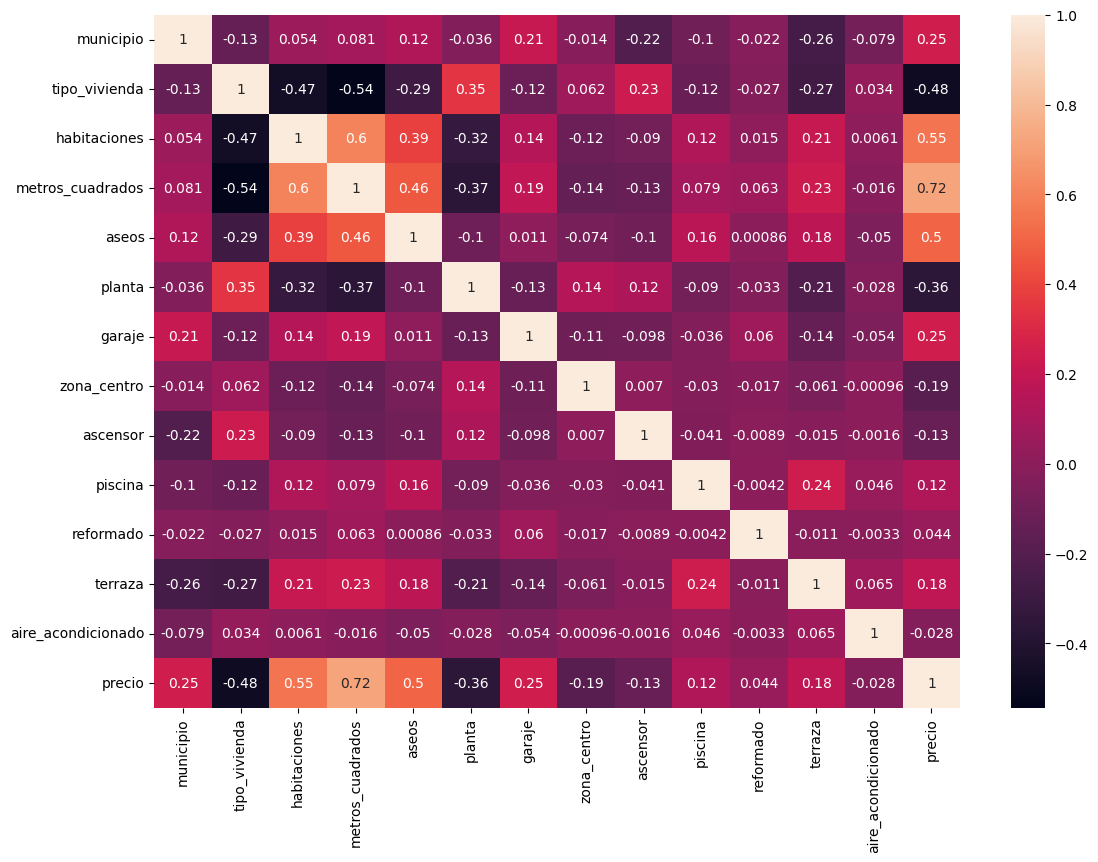

In [5]:
fig = plt.figure(figsize=(13,9))
sns.heatmap(df.corr(), annot=True) # Vemos las correlaciones importantes

<Axes: xlabel='precio', ylabel='Count'>

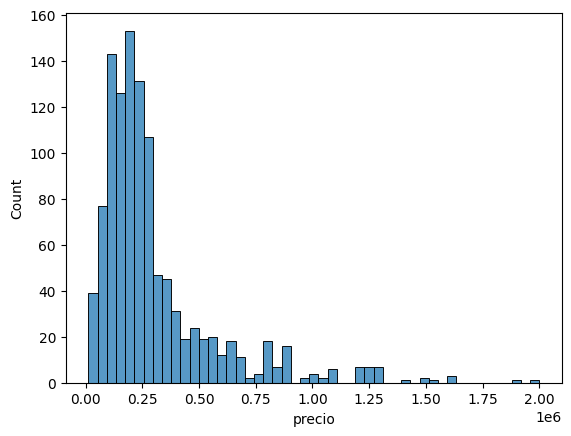

In [6]:
sns.histplot(df["precio"])

## Transformación logarítmica
### En el caso de utilizar arboles **NO es necesario transformar**. Tan sólo al modelo de Regresion Lineal

## Normalización

### **Tampoco requiere normalización**.  Tan sólo al modelo de Regresion Lineal


## Vamos a preparar **código para observar outliers**, *posiblemente eliminarlos* y hacer pruebas para tratar de obtener mejores métricas del modelo sin ellos:

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format) # Para mostrar los numeros completos sin anotacion cientifica

df["precio"].describe()

count      1113.00
mean     302495.07
std      269938.34
min       11800.00
25%      139000.00
50%      220000.00
75%      350000.00
max     2000000.00
Name: precio, dtype: float64

#### Detectamos los valores fuera del rango de los quartiles

Valores fuera de los límites: < 0 o > 666500.0
Cantidad de outliers detectados: 101


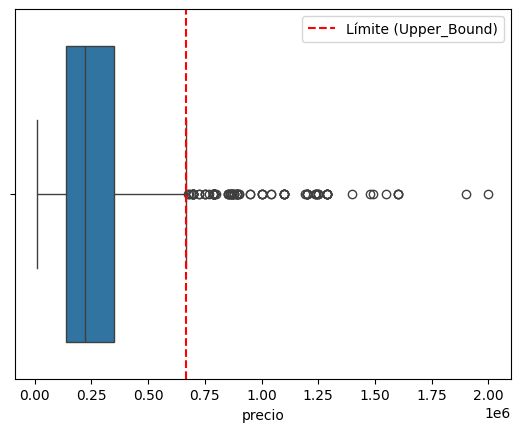

In [4]:
Q1 = df["precio"].quantile(0.25)  # Primer cuartil (25%)
Q3 = df["precio"].quantile(0.75)  # Tercer cuartil (75%)
IQR = Q3 - Q1  # Rango intercuartílico

# Límites para detectar outliers
lower_bound = max(0, Q1 - 1.5 * IQR)  # Ajustar límite inferior a 0 si es negativo
upper_bound = Q3 + 1.5 * IQR

print(f"Valores fuera de los límites: < {lower_bound} o > {upper_bound}")

# Filtrar outliers
outliers = df[df["precio"] > upper_bound]
print(f"Cantidad de outliers detectados: {len(outliers)}")

sns.boxplot(x=df["precio"])
plt.axvline(upper_bound, color='r', linestyle='--', label='Límite (Upper_Bound)')
plt.legend()
plt.show()

#### En caso de eliminarlos, ejecutar la siguiente celda para ajustar el limite de los outliers

Límite superior: 666500.0
Límite superior definitivo a filtrar: 999996.605
Cantidad de outliers detectados ajustados: 42


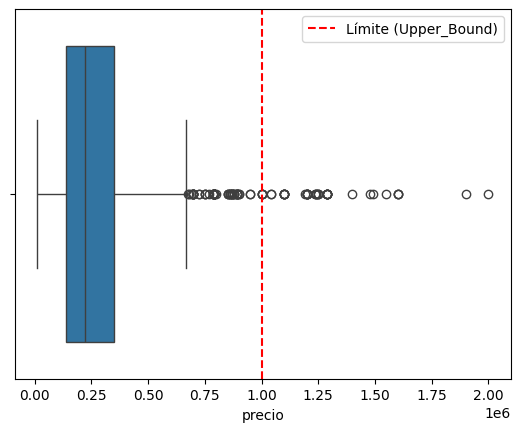

In [5]:
tolerancia = 0.50037  # Incrementa el límite superior del upper_bound (ajusta según tu criterio) # BARRIDO A PARTIR DEL MILLON INCLUSIVE
upper_bound_ajustado = upper_bound + (tolerancia * upper_bound)
print(f"Límite superior: {upper_bound}")
print(f"Límite superior definitivo a filtrar: {upper_bound_ajustado}")

# Filtrar outliers
outliers = df[df["precio"] > upper_bound_ajustado]
print(f"Cantidad de outliers detectados ajustados: {len(outliers)}")

# Visualizar
sns.boxplot(x=df["precio"])
plt.axvline(upper_bound_ajustado, color='r', linestyle='--', label='Límite (Upper_Bound)')
plt.legend()
plt.show()

In [6]:
# Filtrar los datos en el df con el límite ajustado
print(f"Cantidad de datos antes de eliminar outliers: {len(df)}")
df = df[df["precio"] <= upper_bound_ajustado]
print(f"Cantidad de datos después de eliminar outliers: {len(df)}")

Cantidad de datos antes de eliminar outliers: 1113
Cantidad de datos después de eliminar outliers: 1071


In [7]:
df["precio"].value_counts().sort_index(ascending=False)

precio
950000.00    2
900000.00    2
890000.00    6
880000.00    3
870000.00    5
            ..
29000.00     1
27335.00     1
27000.00     2
18000.00     1
11800.00     1
Name: count, Length: 308, dtype: int64

### **Trabajamos sin outliers**, tan sólo con viviendas inferiores a 1M

In [12]:
# import os
# os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # Sustituye '8' por el número de núcleos que deseas usar

### TESTER 1 (xgboost + lightgbm), con todas las columnas, **CON HIPERPARÁMETROS y con pesos**

c:\Users\carlo\miniconda3\envs\data_analysis_env\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\carlo\miniconda3\envs\data_analysis_env\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 10
[LightGBM] [Info] Start training from score 268822.337617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

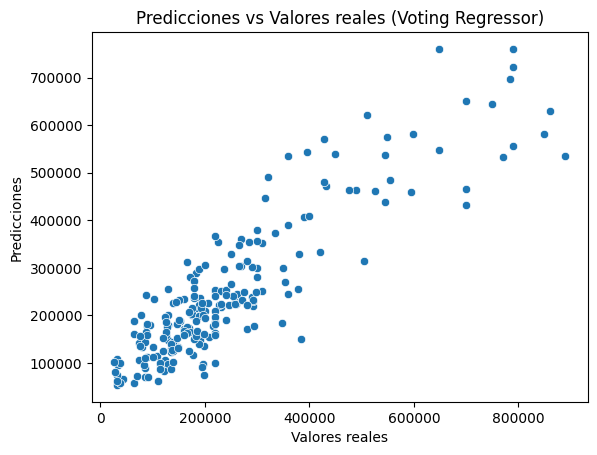

In [8]:
from sklearn.model_selection import train_test_split
# Las columnas de las features (X)

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro', 'ascensor', 'piscina',
       'reformado', 'terraza', 'aire_acondicionado']]

y = df["precio"]  # Target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import VotingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Instanciar modelos individuales
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    random_state=42
)

lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    random_state=42
)

# Crear el Voting Regressor
voting_regressor = VotingRegressor(
    estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    weights=[1, 1]  # Puedes ajustar los pesos según el desempeño individual
)

# Entrenar el modelo combinado
voting_regressor.fit(X_train, y_train)

# Predicciones
y_pred = voting_regressor.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("-----------> MAE:", mae)
print("-----------> MAPE:", mape)
print("-----------> RMSE:", rmse)
print("-----------> R2:", r2)

# Visualización de resultados
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores reales (Voting Regressor)")
plt.show()

### TESTER 2 (xgboost + lightgbm), con todas las columnas. **SIN HIPERPARÁMETROS y sin pesos**

In [9]:
from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define los modelos base
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Define el VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('lgbm', lgbm),
    ('xgb', xgb)
])

# Entrena el modelo
voting_regressor.fit(X_train, y_train)

# Predicciones
y_pred = voting_regressor.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 10
[LightGBM] [Info] Start training from score 268822.337617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

### Sale incluso mejor si no especificamos los hiperparámetros...

## **Implementar RandomizedSearchCV en un VotingRegressor** es un poco diferente porque VotingRegressor en sí mismo no tiene hiperparámetros directos que optimizar. 

### Utilizaremos RandomizedSearchCV para optimizar los hiperparámetros de los modelos individuales (XGBoost, LightGBM) y luego integrar los mejores modelos optimizados dentro del VotingRegressor.

### 1. **Optimizar los Hiperparámetros** de los Modelos Individuales

In [10]:
from sklearn.model_selection import train_test_split
# Las columnas de las features (X)

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro', 'ascensor', 'piscina',
       'reformado', 'terraza', 'aire_acondicionado']]

y = df["precio"]  # Target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb

# Parámetros para XGBoost
param_dist_xgb = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'subsample': [0.5, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)
random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)
best_xgb = random_search_xgb.best_estimator_
print("\n-----> Mejores parámetros para XGBoost:", random_search_xgb.best_params_)

# Parámetros para LightGBM
param_dist_lgb = {
    'n_estimators': [200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 8, 10],
    'subsample': [0.5, 0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search_lgb.fit(X_train, y_train)
best_lgb = random_search_lgb.best_estimator_
print("\n-----> Mejores parámetros para LightGBM:", random_search_lgb.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

-----> Mejores parámetros para XGBoost: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 10
[LightGBM] [Info] Start training from score 268822.337617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

### 2. Crear el **VotingRegressor** con los **Parametros de los Modelos Anteriores**

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 197
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 10
[LightGBM] [Info] Start training from score 268822.337617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

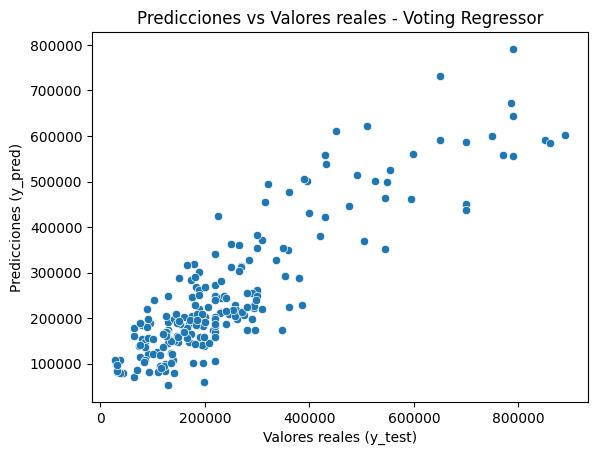

In [23]:
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Crear el VotingRegressor con los mejores modelos
voting_regressor = VotingRegressor(estimators=[
    ('xgb', best_xgb),
    ('lgb', best_lgb)
])

# Entrenar el VotingRegressor
voting_regressor.fit(X_train, y_train)

# Predicciones y evaluación
y_pred = voting_regressor.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

# Visualización
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Predicciones (y_pred)")
plt.title("Predicciones vs Valores reales - Voting Regressor")
plt.show()

### No mejora, empeora un poco

### TESTER 3 (xgboost + lightgbm), **SIN HIPERPARÁMETROS, QUITANDO COLUMNAS** y con **PESOS para los modelos**

In [69]:
# Las columnas de las features (X), descartamos: 'piscina', 'ascensor'

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro',
       'reformado', 'terraza', 'aire_acondicionado']]

y = df["precio"]  # Target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import VotingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define los modelos base
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Define el VotingRegressor
voting_regressor = VotingRegressor(estimators=[
    ('lgbm', lgbm),
    ('xgb', xgb)
], weights=[0.2, 0.9])

# Entrena el modelo
voting_regressor.fit(X_train, y_train)

# Predicciones
y_pred = voting_regressor.predict(X_test)

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 195
[LightGBM] [Info] Number of data points in the train set: 856, number of used features: 9
[LightGBM] [Info] Start training from score 268822.337617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

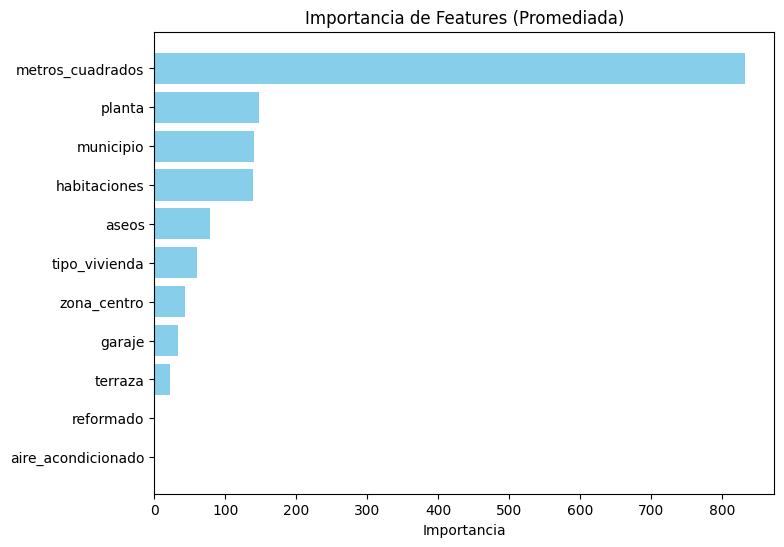

In [65]:
lgbm_model = voting_regressor.estimators_[0]  # LightGBM
xgb_model = voting_regressor.estimators_[1]   # XGBoost

# Importancia de las características de cada modelo
lgbm_importances = lgbm_model.feature_importances_
xgb_importances = xgb_model.feature_importances_
combined_importances = (lgbm_importances + xgb_importances) / 2 # Promedia las importancias

# Ordena las características por importancia
features = X.columns
indices = np.argsort(combined_importances)[::-1]
sorted_importances = combined_importances[indices]
sorted_features = features[indices]

# Gráfica de barras horizontales
plt.figure(figsize=(8, 6))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.title("Importancia de Features (Promediada)")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()  # Invierte el eje y para que las más importantes estén arriba
plt.show()

### Hemos obtenido **mejores métricas**. Por poco, respecto a Gradient Boosting Regressor, pero las tenemos.
### ---> TESTER 3 (lightgbm + xgboost), **SIN HIPERPARÁMETROS, QUITANDO** las columnas de: ***'piscina', 'ascensor'*** y con **PESOS [0.2, 0.9]** para los modelos.
- ### MAE: 57549.45304979046
- ### MAPE: 0.3336779903710622
- ### RMSE: 80476.29853752554
- ### R2: 0.8010465573644786

### Por probar, vamos a repetir la jugada pero **sustituyendo el modelo anterior de menos peso por GradientBoostingRegressor**, ya que en el anterior notebook fue el que mejor metricas nos dió, **manteniendo las columnas definitivas y los pesos de los modelos.**

### TESTER 4 (GradientBoosting + xgboost), **SIN HIPERPARÁMETROS, SIN** las columnas de: ***'piscina', 'ascensor'***
### Y vamos a probar a **NORMALIZAR** antes.

In [30]:
# Las columnas de las features (X), descartamos: 'piscina', 'ascensor', 'reformado'
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df[['municipio', 'tipo_vivienda', 'habitaciones', 'metros_cuadrados',
       'aseos', 'planta', 'garaje', 'zona_centro', 'terraza', 'aire_acondicionado']]

y = df["precio"]  # Target

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# NORMALIZAMOS

# Creo el scaler con los datos de train
scaler_ultimo = StandardScaler() # Z-score

scaler_ultimo.fit(X_train) # Lo "entreno". Calculo su media y std para cada feature solo en el conjunto de entrenamiento.
'''Los targets (y_train) no deben escalarse en este contexto porque no son características, son valores a predecir.'''

X_train = scaler_ultimo.transform(X_train) # Aplico el scaler y sobreescribo los datos de train
print("X_train", X_train[0],"\n") # Se muestra la primera fila de ejemplo para ver la normalización

# Aplico el mismo scaler con los datos de test
X_test = scaler_ultimo.transform(X_test)
print("X_test", X_test[0],"\n")

# print("Total shape:", X.shape)
# print("Train features shape (X):", X_train.shape)
# print("Train target shape (y):", y_train.shape)
# print("Test features shape (X):", X_test.shape)
# print("Test target shape (y):", y_test.shape)
# print()

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

# Define los modelos base
gbr = GradientBoostingRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)

# Define el VotingRegressor
voting_regressor_ultimo = VotingRegressor(estimators=[
    ('gbr', gbr),
    ('xgb', xgb)
], weights=[0.2, 1])

# Entrena el modelo
voting_regressor_ultimo.fit(X_train, y_train)

# Predicciones
y_pred = voting_regressor_ultimo.predict(X_test)

print(gbr, "\n")
print(xgb, "\n")

# Métricas de evaluación
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2:", r2)

# METRICAS SIN LA NORMALIZACIÓN
## MAE: 57254.881733606686
## MAPE: 0.3299150682002329
## RMSE: 79887.35412765635
## R2: 0.8039478779275562

X_train [-0.70629384  0.77165537  0.55857977 -0.72360293  0.07411759  1.55029006
 -0.47392677 -0.55575939 -0.36369648 -0.09712859] 

X_test [-0.70629384  0.77165537 -0.31077347 -0.23279143  0.07411759 -0.60838955
 -0.47392677  1.79933981 -0.36369648 -0.09712859] 

GradientBoostingRegressor(random_state=42) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
    

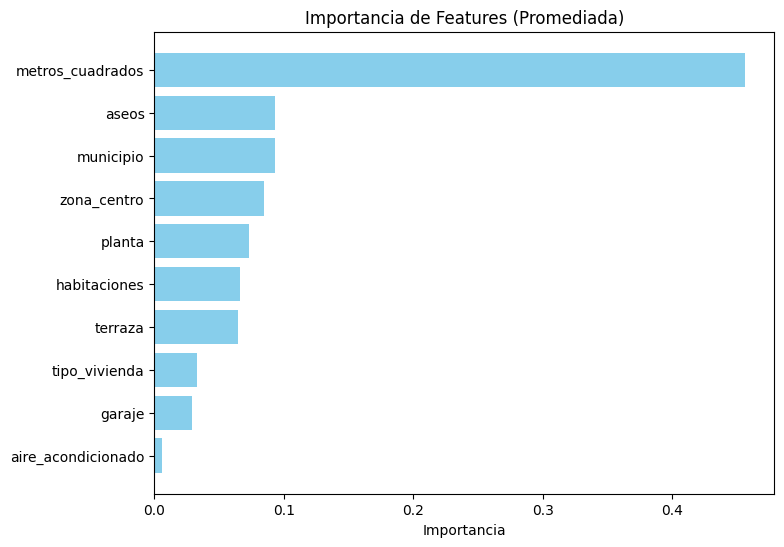

In [11]:
gbr_model = voting_regressor_ultimo.estimators_[0]  # gbr
xgb_model = voting_regressor_ultimo.estimators_[1]   # XGBoost

# Importancia de las características de cada modelo
gbr_importances = gbr_model.feature_importances_
xgb_importances = xgb_model.feature_importances_
combined_importances = (gbr_importances + xgb_importances) / 2 # Promedia las importancias

# Ordena las características por importancia
features = X.columns
indices = np.argsort(combined_importances)[::-1]
sorted_importances = combined_importances[indices]
sorted_features = features[indices]

# Gráfica de barras horizontales
plt.figure(figsize=(8, 6))
plt.barh(sorted_features, sorted_importances, color="skyblue")
plt.title("Importancia de Features (Promediada)")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()  # Invierte el eje y para que las más importantes estén arriba
plt.show()

### Hemos obtenido **las mejores métricas del proyecto!** con muy poca diferencia respecto a la anterior prueba, pero las tenemos.
### ---> TESTER 4 (***GradientBoosting + xgboost***), **SIN HIPERPARÁMETROS**, **con NORMALIZACIÓN**,
### **QUITANDO** las columnas: ***'piscina', 'ascensor', 'reformado'*** y con **PESOS [0.2, 1]** para los modelos:

- ### MAE: 57174.55626981096
- ### MAPE: 0.3293120920224783
- ### RMSE: 79853.99354053184
- ### R2: 0.8041115846455356

In [12]:
df["precio"].describe()

count     1071.00
mean    264474.43
std     188307.03
min      11800.00
25%     135000.00
50%     210000.00
75%     311000.00
max     950000.00
Name: precio, dtype: float64

## **Con base en la estadistica del target** (df["precio"].describe()):

- ### **MAE (57,174.55)**: El modelo, en promedio, **tiene un error absoluto de alrededor de 57,174 euros** al predecir el precio de una vivienda. Dado que el precio **promedio** de una vivienda **es de 264,474.43 euros**, esto **equivale a un error absoluto promedio de 21.6%** del valor medio.

- ### **MAPE (0.3293)**: El modelo tiene un **error porcentual promedio del 32.99% respecto al valor real.** Esto puede ser más relevante para viviendas más económicas, donde el impacto del error relativo es mayor.

- ### **MSE (79,853.99)**: Es una **métrica más sensible** a los grandes errores (outliers). En comparación con el rango de precios (mínimo de 11,800 y máximo de 950,000), este valor indica que **el modelo puede manejar tanto valores altos como bajos con un error razonable.**

- ### **R2 (0.8041)**: El modelo **explica el 80.41% de la variabilidad en los precios** de las viviendas. Esto indica un **buen ajuste, pero aún hay margen de mejora** en la captura de ciertas variabilidades (quizás por factores no considerados).

## **Guardamos y exportamos** este último modelo.
### Al igual que el **StandardScaler()**, porque **hubo normalización** para este modelo.

In [67]:
import joblib

# Exporta el modelo entrenado
joblib.dump(voting_regressor_ultimo, "Gradient_XGB_model.pkl")
print("Modelo exportado como 'Gradient_XGB_model.pkl'")

# Exporta la normalización empleada
joblib.dump(scaler_ultimo, 'scaler_voting.pkl')

Modelo exportado como 'Gradient_XGB_model.pkl'


['scaler_voting.pkl']

## Listo, una vez guardados el modelo y el escalador, en el notebook ***testing_model.ipynb*** se carga el modelo y se testea con datos de nuevas viviendas para probar su rendimiento!

## Los gráficos de a continuación son observaciones que se tendrán en cuenta a la hora de mejorar el modelo y requerir una mayor precisión, pero **de momento crearemos la aplicacion Streamlit y probaremos tasaciones con la versión actual.**

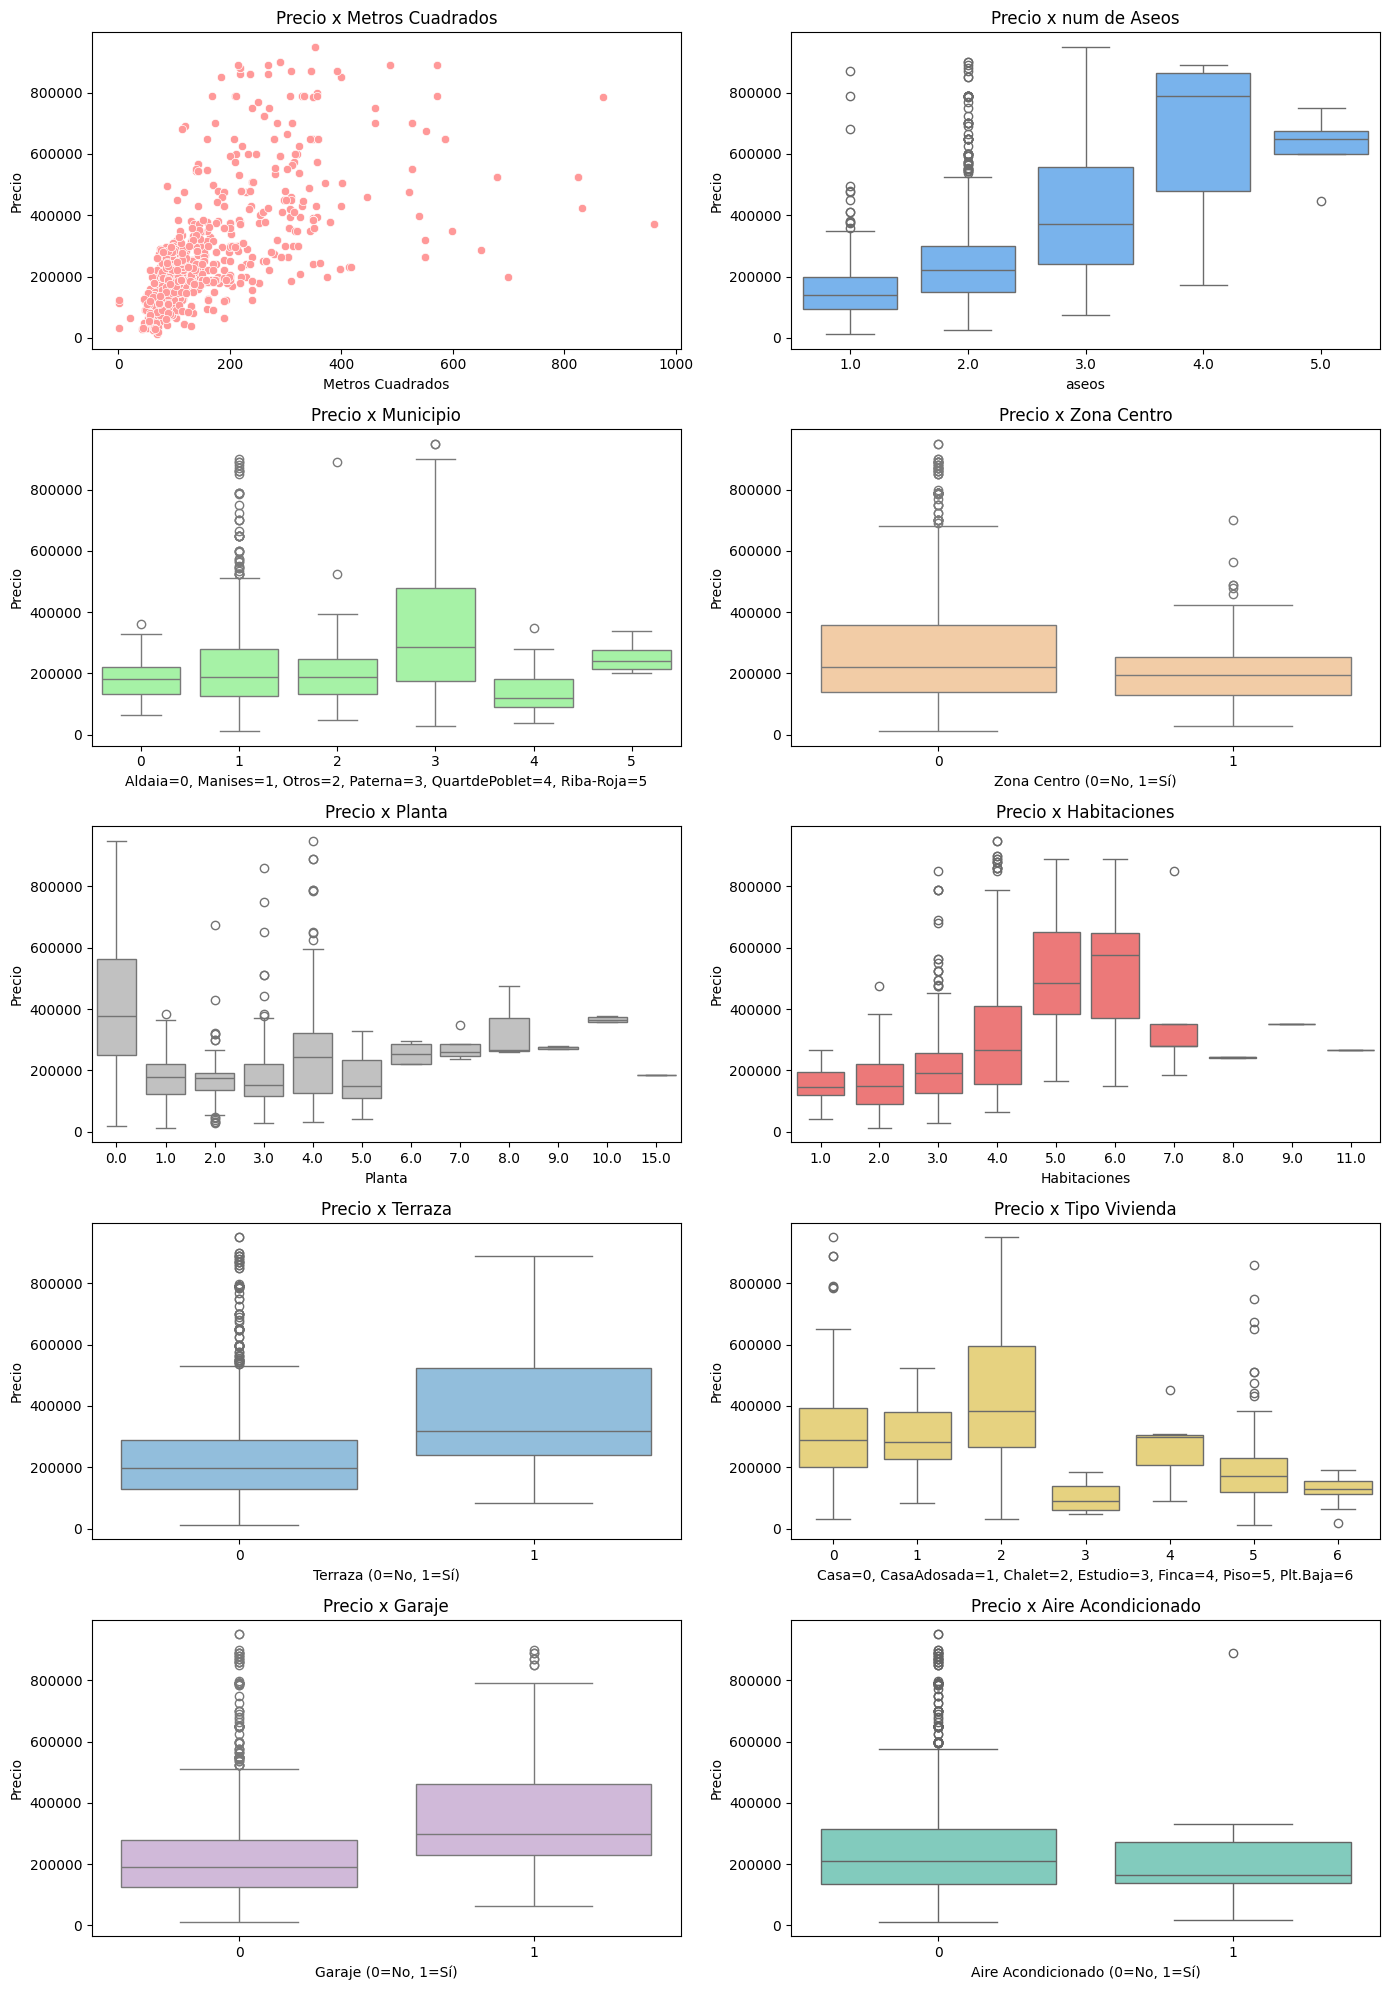

In [34]:
# Crear una figura con subplots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))
axes = axes.flatten()

# Paleta de colores
colors = ["#FF9999", "#66B3FF", "#99FF99", "#FFCC99", "#C1C1C1",
          "#FF6666", "#85C1E9", "#F7DC6F", "#D2B4DE", "#76D7C4"]

# Relación entre metros_cuadrados y precio
sns.scatterplot(x=df['metros_cuadrados'], y=df['precio'], ax=axes[0], color=colors[0])
axes[0].set_title("Precio x Metros Cuadrados")
axes[0].set_xlabel("Metros Cuadrados")
axes[0].set_ylabel("Precio")

# Boxplot para aseos
sns.boxplot(x=df['aseos'], y=df['precio'], ax=axes[1], color=colors[1])
axes[1].set_title("Precio x num de Aseos")
axes[1].set_ylabel("Precio")

# Boxplot para municipio
sns.boxplot(x=df['municipio'], y=df['precio'], ax=axes[2], color=colors[2])
axes[2].set_title("Precio x Municipio")
axes[2].set_xlabel("Aldaia=0, Manises=1, Otros=2, Paterna=3, QuartdePoblet=4, Riba-Roja=5")
axes[2].set_ylabel("Precio")

# Boxplot para zona_centro
sns.boxplot(x=df['zona_centro'], y=df['precio'], ax=axes[3], color=colors[3])
axes[3].set_title("Precio x Zona Centro")
axes[3].set_xlabel("Zona Centro (0=No, 1=Sí)")
axes[3].set_ylabel("Precio")

# Boxplot para planta
sns.boxplot(x=df['planta'], y=df['precio'], ax=axes[4], color=colors[4])
axes[4].set_title("Precio x Planta")
axes[4].set_xlabel("Planta")
axes[4].set_ylabel("Precio")

# Boxplot para habitaciones
sns.boxplot(x=df['habitaciones'], y=df['precio'], ax=axes[5], color=colors[5])
axes[5].set_title("Precio x Habitaciones")
axes[5].set_xlabel("Habitaciones")
axes[5].set_ylabel("Precio")

# Boxplot para terraza
sns.boxplot(x=df['terraza'], y=df['precio'], ax=axes[6], color=colors[6])
axes[6].set_title("Precio x Terraza")
axes[6].set_xlabel("Terraza (0=No, 1=Sí)")
axes[6].set_ylabel("Precio")

# Boxplot para tipo vivienda
sns.boxplot(x=df['tipo_vivienda'], y=df['precio'], ax=axes[7], color=colors[7])
axes[7].set_title("Precio x Tipo Vivienda")
axes[7].set_xlabel("Casa=0, CasaAdosada=1, Chalet=2, Estudio=3, Finca=4, Piso=5, Plt.Baja=6")
axes[7].set_ylabel("Precio")

# Boxplot para Garaje
sns.boxplot(x=df['garaje'], y=df['precio'], ax=axes[8], color=colors[8])
axes[8].set_title("Precio x Garaje")
axes[8].set_xlabel("Garaje (0=No, 1=Sí)")
axes[8].set_ylabel("Precio")

# Boxplot para aire acondicionado
sns.boxplot(x=df['aire_acondicionado'], y=df['precio'], ax=axes[9], color=colors[9])
axes[9].set_title("Precio x Aire Acondicionado")
axes[9].set_xlabel("Aire Acondicionado (0=No, 1=Sí)")
axes[9].set_ylabel("Precio")

# Ajustar diseño
plt.tight_layout()
plt.show()


### Observaciones:
- #### **M2**: No es precisamente lineal...
- #### **Zona_centro**: No tiene mucho sentido ya que, en la **zona céntrica hay tipos de viviendas generalmente más baratos** que **en las afueras**, donde hay ***Chalets, Fincas y Casas Adosadas***
- #### **Planta**: La **planta 0** son ***Chalets, Fincas, Casas y Casas Adosadas*** y éstas de normal tienen **precios más elevados.**
- #### **Habitaciones**: Algo lineal pero, **¿Qué ocurre a partir de la 6º habitación?**
- #### **Aire Acondicionado**: No tiene mucho sentido, es irrelevante, por lo que podría descartarse

### Vemos algunas agrupaciones para entender relaciones de las features observadas.

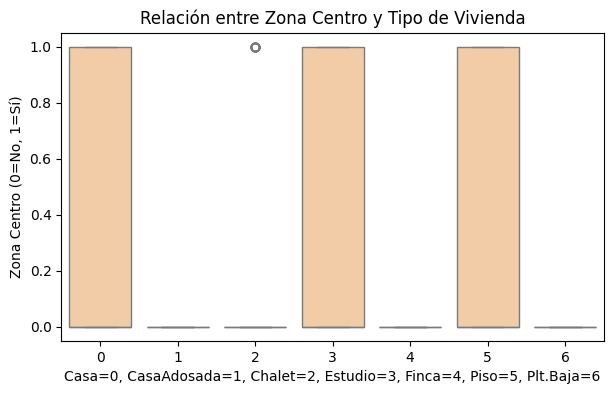

In [32]:
# Relación entre zona_centro y tipo de vivienda
plt.figure(figsize=(7, 4))
sns.boxplot(x=df['tipo_vivienda'], y=df['zona_centro'], color="#FFCC99")
plt.title("Relación entre Zona Centro y Tipo de Vivienda")
plt.xlabel("Casa=0, CasaAdosada=1, Chalet=2, Estudio=3, Finca=4, Piso=5, Plt.Baja=6")
plt.ylabel("Zona Centro (0=No, 1=Sí)")
plt.show();

### Se ve claramente que las únicas viviendas que pueden considerarse en zona centro son: **Casa, Estudio y Piso**

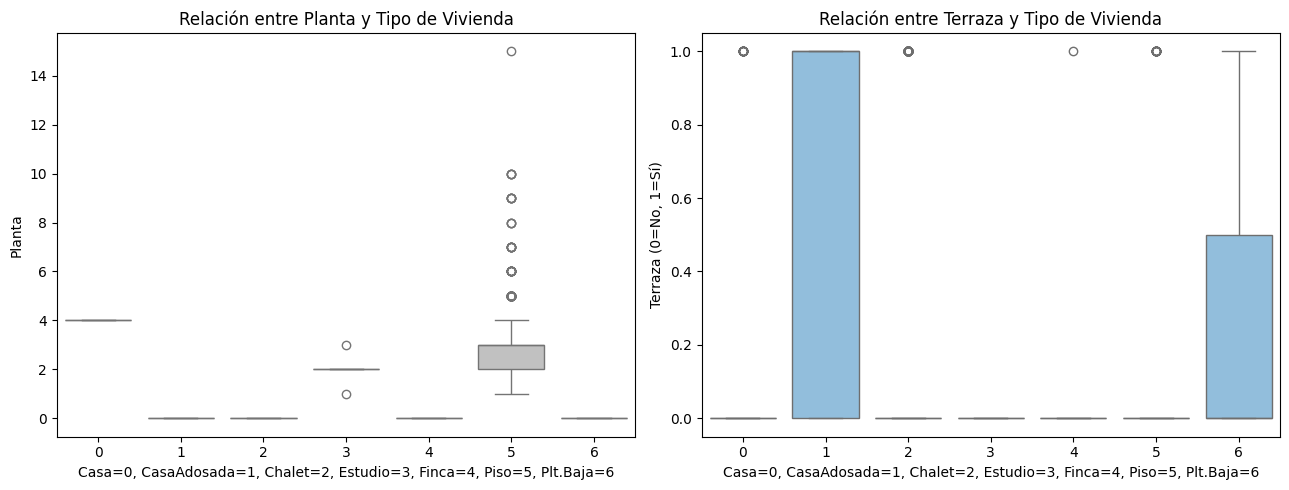

In [47]:
# Crear una figura con subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
axes = axes.flatten()

# Relación entre planta y tipo de vivienda
sns.boxplot(x=df['tipo_vivienda'], y=df['planta'], ax=axes[0], color="#C1C1C1")
axes[0].set_title("Relación entre Planta y Tipo de Vivienda")
axes[0].set_xlabel("Casa=0, CasaAdosada=1, Chalet=2, Estudio=3, Finca=4, Piso=5, Plt.Baja=6")
axes[0].set_ylabel("Planta")

# Relación entre terraza y tipo de vivienda 
sns.boxplot(x=df['tipo_vivienda'], y=df['terraza'], ax=axes[1], color="#85C1E9")
axes[1].set_title("Relación entre Terraza y Tipo de Vivienda")
axes[1].set_xlabel("Casa=0, CasaAdosada=1, Chalet=2, Estudio=3, Finca=4, Piso=5, Plt.Baja=6")
axes[1].set_ylabel("Terraza (0=No, 1=Sí)")

# Ajustar diseño
plt.tight_layout()
plt.show();

### Puede que "Casa" con altura 4 sea atípico, pero las **únicas viviendas que sí tienen altura son Estudio y Piso**

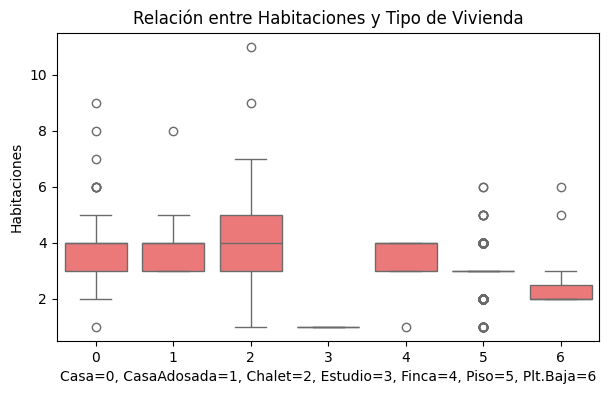

In [44]:
# Relación entre Habitaciones y Tipo de Vivienda
plt.figure(figsize=(7, 4))
sns.boxplot(x=df['tipo_vivienda'], y=df['habitaciones'], color="#FF6666")
plt.title("Relación entre Habitaciones y Tipo de Vivienda")
plt.xlabel("Casa=0, CasaAdosada=1, Chalet=2, Estudio=3, Finca=4, Piso=5, Plt.Baja=6")
plt.ylabel("Habitaciones")
plt.show();

### Parece que entre "Casa" y "Casa Adosada" hay pique, aunque "Casa" muestra mayor numero de habitaciones, pero puede haber algun error ya que anteriormente vimos respecto al precio que a partir de 6 habitaciones el precio disminuye...

### "Estudio" la que menos tiene, "Finca" por el estilo de las "Casas" y "Chalet", "Piso" parece que bien, pero "Plt.Baja" me extraña un poco... Quizás se ha colado alguna "Casa" como "Plt.Baja".

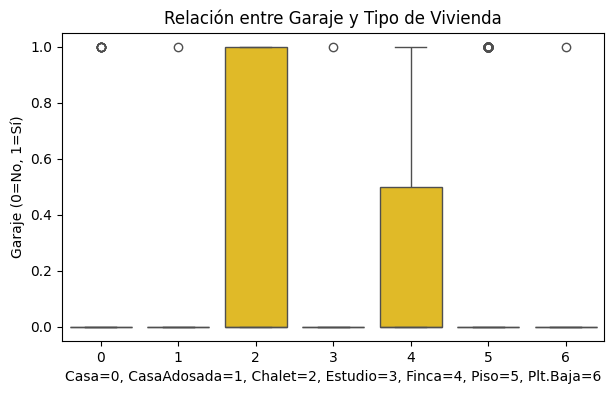

In [46]:
# Relación entre garaje y tipo de vivienda
plt.figure(figsize=(7, 4))
sns.boxplot(x=df['tipo_vivienda'], y=df['garaje'], color="#FFCC09")
plt.title("Relación entre Garaje y Tipo de Vivienda")
plt.xlabel("Casa=0, CasaAdosada=1, Chalet=2, Estudio=3, Finca=4, Piso=5, Plt.Baja=6")
plt.ylabel("Garaje (0=No, 1=Sí)")
plt.show();